# MSAI349: Homework 3
Authors: Sayantani Bhattacharya, Harrison Bounds, Andrew Kwolek, Sharwin Patil

In [12]:
# Import Block
import torch.nn as nn
import torch
from torch import Tensor
from torch.optim import Optimizer
from tqdm import tqdm
import os

from typing import Callable, Tuple
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np

# Plotting Code
Plotting code provided in starter code

In [19]:
# %matplotlib inline

################################################################################
# Some simple plotting utilities
################################################################################


def plot_data(data: np.ndarray,
              labels: np.ndarray,
              ax: matplotlib.axes.Axes = None):
    """
    A helper function to plot our data sets

    PARAMETERS
    ----------
    data      A numpy array of 2 columns (dimensions) and 2*examples_per_class rows

    labels    A numpy vector with 2*examples_per_class, with a +1 or -1 in each
              element. The jth element is the label of the jth example

    ax        An optional matplotlib axis object to plot to
    """

    # require shape (n, 2)
    assert data.ndim == 2
    assert data.shape[-1] == 2

    if type(data) == torch.Tensor:
        data = data.numpy()

    # plot the data
    pos_idx = np.where(labels == 1)
    neg_idx = np.where(labels == -1)

    if ax is None:
        ax = plt
    ax.plot(
        data.T[0, pos_idx],
        data.T[1, pos_idx],
        'r^',
        label='positive'
    )
    ax.plot(
        data.T[0, neg_idx],
        data.T[1, neg_idx],
        'bo',
        label='negative'
    )
    ax.axis('equal')
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc="upper right")

    if ax is None:
        plt.show()


def plot_decision_surface(model=None,
                          axis_limits=(-5, 5, -5, 5),
                          ax: matplotlib.axes.Axes = None
                          ):
    """
    Creates a grid of points, measures what a model would label each
    point as, and uses this data to draw a region for class +1 and a region for
    class -1.

    PARAMETERS
    ----------
    model       A callable model that can take 2-d real-valued input and produce
                a +1 or -1 label for each data point.

    axis_limits An array-like object with 4 floats [lowest_horizontal, highest_horizontal,
                lowest_vertical, highest_vertical]. This sets the limits over which
                the decision surface will be caluclated and plotted.

    ax          An optional matplotlib axis object to plot to

    RETURNS
    -------
    my_contour  a matplotlib.contour.QuadContourSet with the contour
    """

    # Create a grid of points spanning the entire space displayed in the axis.
    # This will let us draw the decision boundary later
    xx, yy = np.meshgrid(np.arange(axis_limits[0], axis_limits[1], .05),
                         np.arange(axis_limits[2], axis_limits[3], .05))
    data = np.concatenate([xx.reshape([1, -1]), yy.reshape([1, -1])]).T

    # Predict the class of each point in XGrid, using the classifier.
    # This shows our regions determined by the classifier
    if isinstance(model, nn.Module):
        with torch.no_grad():
            pl = model(torch.tensor(data).to(dtype=torch.float32))
            predicted_labels = np.sign(pl.numpy())
    else:
        predicted_labels = model(data)

    predicted_labels = predicted_labels.reshape(xx.shape)

    # Put the result into a color plot
    if ax is None:
        ax = plt

    ax.contourf(xx, yy, predicted_labels, cmap=plt.cm.Paired)
    ax.axis('equal')
    ax.axis('tight')

    if ax is None:
        plt.show()


def compute_bounds(features):
    min1, max1 = features[:, 0].min()-1, features[:, 0].max()+1
    min2, max2 = features[:, 1].min()-1, features[:, 1].max()+1
    return (min1, max1, min2, max2)


def plot_decision_regions(
        features, targets, model,
        axis=None, transform=None,
        bounds=None,
        title='Decision Surface'):
    """
    Slightly different plotting approach than above. Used in backprop demo.

    This function produces a single plot containing a scatter plot of the
    features, targets, and decision region of the model.

    Args:
        features (np.ndarray): 2D array containing real-valued inputs.
        targets (np.ndarray): 1D array containing binary targets.
        model: a learner with .predict() method
        axis: the axis on which to plot. If None, create a new plot
        title: title of the plot
    Returns:
        None (plots to the active figure)
    """

    # define bounds of the domain
    if bounds is None:
        min1, max1, min2, max2 = compute_bounds(features)
    else:
        min1, max1, min2, max2 = bounds

    # define grid for visualizing decision regions
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)

    xx, yy = np.meshgrid(x1grid, x2grid)

    # flatten grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))

    # horizontally stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1, r2))

    # if we're transforming the features, do that now
    #     this allows xx and yy to still be in 2D for the visualization
    #     but grid has been transformed so it matches up with the fit model
    if transform is not None:
        grid = transform(grid)

    # generate predictions over grid
    # Cast grid to a tensor if model is a PyTorch model
    if isinstance(model, nn.Module):
        grid = torch.tensor(grid).to(dtype=torch.float32)
    yhat = model.predict(grid)

    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)

    if axis is None:
        fig, axis = plt.subplots()

    # plot the grid of x, y and z values as a surface
    binary_cmap = matplotlib.colors.ListedColormap(['#9ce8ff', '#ffc773'])
    axis.contourf(xx, yy, zz, cmap=binary_cmap, alpha=0.7)

    # plot "negative" class:
    row_idx_neg = np.where(targets < 0.5)[0]
    axis.scatter(
        features[row_idx_neg, 0], features[row_idx_neg, 1],
        label='negative')

    # plot "positive" class:
    row_idx_pos = np.where(targets > 0.5)[0]
    axis.scatter(
        features[row_idx_pos, 0], features[row_idx_pos, 1],
        label='positive')

    axis.set_title(title)
    axis.set_xlim(min1, max1)
    axis.set_ylim(min2, max2)

    axis.legend(loc="upper left")

# Part 1 & 2
PyTorch Implementaion with MCE and MSE.

In [14]:
class NeuralNet(nn.Module):
    def __init__(self, input_size: int, hl_size: int, output_size: int, regularizer: str = None):
        """Initialize the network with the size of each layer

        Args:
            input_size (int): Number of features in the dataset
            hl_size (int): hidden layer size
            output_size (int): output size (1 for MSE loss, 2 for MCE loss)
            regularizer (str, optional): Regularization term [norm, orthogonal]. Defaults to None.
        """
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hl_size = hl_size
        self.output_size = output_size
        self.linear1 = nn.Linear(input_size, hl_size)
        self.sigmoid1 = nn.Sigmoid()
        self.linear2 = nn.Linear(hl_size, output_size)
        if output_size == 2:
            self.output = nn.Softmax()
        elif output_size == 1:
            self.output = nn.Sigmoid()
        self.regularizer = regularizer
        self.regularizer_lambda = 0.01
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using {self.device} for training")

    def forward(self, x: Tensor) -> Tensor:
        """Forward pass for the neural network

        Args:
            x (Tensor): Input data in the form of a tensor

        Returns:
            Tensor: data after the nework has processed it (output tensor)
        """
        x = self.linear1(x)
        x = self.sigmoid1(x)
        x = self.linear2(x)
        x = self.output(x)
        return x

    def train_model(self, model: nn.Module, num_epochs: int, X_train: Tensor, y_train: Tensor, X_valid: Tensor, y_valid: Tensor, loss_func: Callable, optimizer: Optimizer) -> list:
        """Use Stochastic Gradient Descent to train one example at a time

        Args:
            model (nn.Module): Model created by the forward pass
            num_epochs (int): Number of times to train the entire dataset
            X_train (Tensor): Training data without labels
            y_train (Tensor): Labels for the training data
            X_valid (Tensor): Validation data without labels
            y_valid (Tensor): Labels for the validation data
            loss_func (Callable): callable function to perform the loss calculation on the output
            optimizer (Optimizer): Built in optimzer to perform momentum based learning
        """
        training_learning_curve = []
        validation_learning_curve = []
        for epoch in range(num_epochs):
            model.train()
            training_loss = 0
            for i in range(len(X_train)):

                x = X_train[i]
                y = y_train[i]

                y_pred = model(x)
                loss = loss_func(y_pred, y)

                if self.regularizer == "norm":
                    input_layer_weights = model.linear1.weight
                    regularizer_value = torch.sum(input_layer_weights ** 2)
                    loss += self.regularizer_lambda * regularizer_value
                elif self.regularizer == "orthogonal":
                    # encourage orthogonality in the intermediate decision
                    # boundaries learned in the first layer
                    input_layer_weights = model.linear1.weight
                    dot_products = torch.mm(
                        input_layer_weights, input_layer_weights.t()
                    )
                    identity = torch.eye(dot_products.shape[0])
                    orthogonality_loss = torch.sum(
                        (dot_products - identity) ** 2)
                    loss += self.regularizer_lambda * orthogonality_loss

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss for the epoch
                training_loss += loss.item()
            # Learning curve should be average loss per epoch
            training_learning_curve.append(training_loss / len(X_train))
            # Validation Phase
            model.eval()
            with torch.no_grad():
                validation_loss = 0
                for i in range(len(X_valid)):
                    x_valid = X_valid[i]
                    y_val = y_valid[i]

                    y_valid_pred = model(x_valid)
                    loss = loss_func(y_valid_pred, y_val)
                    validation_loss += loss.item()
                # Learning curve should be average loss per epoch
                validation_learning_curve.append(
                    validation_loss / len(X_valid))

        return training_learning_curve, validation_learning_curve

    def predict(self, X: Tensor) -> Tensor:
        """Predict the output of the network

        Args:
            X (Tensor): Input data without labels

        Returns:
            Tensor: Predicted output of the network
        """
        model = self
        model.eval()
        with torch.no_grad():
            return model(X)

    def validate_test(self, model: nn.Module, X_test: Tensor, y_test: Tensor, loss_func_label: str) -> float:
        """Test the validation and test set accuracies by divinding the correct predictions by the total predicitions

        Args:
            model (nn.Module): Model created by the forward pass
            X_test (Tensor): Testing/Validation data without labels
            y_test (Tensor): Labels for the testing/validation data
            loss_func_label (str): Specifies either MSE or MCE loss

        Returns:
            float: accuracy evaluation metric to see how well the network is performing
        """
        model.eval()  # Set the model to 'evaluation' mode
        # Disable gradient calculation for testing
        with torch.no_grad():
            correct = 0
            total = 0
            for i in range(len(X_test)):
                x = X_test[i]
                y = y_test[i]

                if loss_func_label == "MCE":
                    # Second probability in output: (Second probability so we can keep the logic the same for clipping)
                    pred = model(x)[1]
                elif loss_func_label == "MSE":
                    pred = model(x)

                # Clipping: If the second element has higher than a 50% probability, then it is of class 1, otherwise class 0
                pred = 1 if pred >= 0.5 else 0

                if pred == y:
                    correct += 1

                total += 1

        accuracy = correct / total

        return accuracy


class HyperParams:
    def __init__(self, hidden_layer_size: int, learning_rate: float, loss_func: str):
        self._hl_size = hidden_layer_size
        self._lr = learning_rate
        self._output_size = 2 if loss_func == "MCE" else 1

    def __hash__(self):
        return hash((self.hl_size, self.lr, self.output_size))

    def __repr__(self):
        return f"[HLSize: {self.hl_size}, LR: {self.lr}, Loss: {'MCE' if self.output_size == 2 else 'MSE'}]"

    @property
    def hl_size(self):
        return self._hl_size

    @property
    def lr(self):
        return self._lr

    @property
    def output_size(self):
        return self._output_size


class NeuralNetEvaluator:
    def __init__(
            self,
            training_data: dict[str: str],
            test_data: dict[str: str],
            validation_data: dict[str: str],
            loss_functions: dict[str: Callable]):
        self.training_data = training_data
        self.test_data = test_data
        self.validation_data = validation_data
        self.loss_functions = loss_functions
        self.used_regularizer = ""

        # Store the evaluated models as a dictionary that maps
        # a tuple of the dataset name and the hyperparams to a
        # dictionary of accuracy_names to accuracy values
        # Example Entry: ("dataset_name", HyperParams): {"valid_accuracy": 0.5, "test_accuracy": 0.6}
        self.evaluated_models: dict[
            Tuple[str, HyperParams]: dict[str: float]
        ] = {}
        # Store the best models as a map of
        # dataset_name_loss to the model itself
        self.all_models: dict[str: dict[HyperParams: NeuralNet]] = {}
        self.best_models: dict[str: NeuralNet] = {}

    def train_model(
            self,
            dataset_name: str,
            loss_func_name: str,
            regularizer: str,
            hyperparams: HyperParams):
        # Assign hyperparams to default if not provided
        # Convert data to tensors
        X_train = pd.read_csv(self.training_data[dataset_name])
        X_test = pd.read_csv(self.test_data[dataset_name])
        X_validation = pd.read_csv(self.validation_data[dataset_name])
        # Seperate labels
        y_train = X_train["label"].values
        y_test = X_test["label"].values
        y_validation = X_validation["label"].values
        # Drop labels
        X_train = X_train.drop("label", axis=1).values
        X_test = X_test.drop("label", axis=1).values
        X_validation = X_validation.drop("label", axis=1).values
        # Convert to tensors for numpy to use
        X_train = torch.tensor(X_train, dtype=torch.float32)
        X_test = torch.tensor(X_test, dtype=torch.float32)
        X_validation = torch.tensor(X_validation, dtype=torch.float32)
        # For MCE, we need to convert the labels to long
        if loss_func_name == "MCE":
            y_train = torch.tensor(y_train, dtype=torch.long)
            y_test = torch.tensor(y_test, dtype=torch.long)
            y_validation = torch.tensor(y_validation, dtype=torch.long)
        elif loss_func_name == "MSE":
            y_train = torch.tensor(y_train, dtype=torch.float32)
            y_test = torch.tensor(y_test, dtype=torch.float32)
            y_validation = torch.tensor(y_validation, dtype=torch.float32)
        # Build network with loss function and optimizer
        if regularizer is not None or regularizer != "":
            self.used_regularizer = regularizer
        neural_network = NeuralNet(
            X_train.shape[1],
            hl_size=hyperparams.hl_size,
            output_size=2 if loss_func_name == "MCE" else 1,
            regularizer=regularizer if regularizer != "" else None
        )
        loss_func = self.loss_functions[loss_func_name]
        optimizer = torch.optim.Adam(
            neural_network.parameters(),
            lr=hyperparams.lr
        )
        # Train the model
        training_losses, validation_losses = neural_network.train_model(
            neural_network,
            num_epochs=500,
            X_train=X_train,
            y_train=y_train,
            X_valid=X_validation,
            y_valid=y_validation,
            loss_func=loss_func,
            optimizer=optimizer
        )
        # Evaluate the model
        valid_accuracy = neural_network.validate_test(
            neural_network,
            X_validation,
            y_validation,
            loss_func_name
        )
        test_accuracy = neural_network.validate_test(
            neural_network,
            X_test,
            y_test,
            loss_func_name
        )
        # Save the accuracy to the evaluated models
        key = (dataset_name, hyperparams)
        self.evaluated_models[key] = {
            "valid_accuracy": valid_accuracy,
            "test_accuracy": test_accuracy,
            "training_losses": training_losses,
            "validation_losses": validation_losses
        }
        dataset_loss = f"{dataset_name}_{loss_func_name}"
        if dataset_loss not in self.all_models:
            self.all_models[dataset_loss] = {}
        self.all_models[dataset_loss][hyperparams] = neural_network
        print(
            f"Finished training {dataset_name} with Hyperparams: {hyperparams}" +
            f" with loss function: {
                loss_func_name} and regularizer: {"None" if regularizer == "" else regularizer}"
        )

    def print_evaluated_models(self):
        unique_datasets = set([key[0] for key in self.evaluated_models.keys()])
        print(
            f'Evaluated {len(self.evaluated_models)} models over ' +
            f'{len(unique_datasets)} datasets'
        )
        for key in self.evaluated_models.keys():
            dataset_name, hyper_params = key
            valid_accuracy = self.evaluated_models[key]["valid_accuracy"]
            test_accuracy = self.evaluated_models[key]["test_accuracy"]
            print("======================================")
            print(f"{dataset_name} with Hyperparams: {hyper_params}")
            print(f"Validation Accuracy: {valid_accuracy}")
            print(f"Test Accuracy: {test_accuracy}")
            print("======================================\n")

    def find_best_hyperparams_for_dataset(self, dataset_name: str, loss_func_name: str):
        # This assumes that the models are already trained and stored
        best_test_accuracy = 0
        best_valid_accuracy = 0
        best_hyperparams = None
        # dataset_models should be all the models where the dataset_name is the key
        loss_output_size = 2 if loss_func_name == "MCE" else 1
        dataset_models = [
            key for key in self.evaluated_models.keys() if key[0] == dataset_name and key[1].output_size == loss_output_size
        ]
        for key in dataset_models:
            dataset, hp = key
            valid_accuracy = self.evaluated_models[key]["valid_accuracy"]
            test_accuracy = self.evaluated_models[key]["test_accuracy"]
            if valid_accuracy > best_valid_accuracy:
                best_test_accuracy = test_accuracy
                best_valid_accuracy = valid_accuracy
                best_hyperparams = hp
        dataset_loss = f"{dataset_name}_{loss_func_name}"
        model_dict = self.all_models[dataset_loss]
        # Find the entry that matches the best hyperparams
        best_model = model_dict[best_hyperparams]
        self.best_models[dataset_loss] = best_model
        return best_hyperparams, best_valid_accuracy, best_test_accuracy

    def plot_learning_curves(self, dataset_name: str, best_hp: HyperParams):
        # Plot the learning curve for training and validation loss as
        # a function of training epochs
        # find the epoch_losses for the best hyperparams
        key = (dataset_name, best_hp)
        loss = "MCE" if best_hp.output_size == 2 else "MSE"
        training_losses = self.evaluated_models[key]["training_losses"]
        validation_losses = self.evaluated_models[key]["validation_losses"]
        plt.figure()
        if self.used_regularizer is not None or self.used_regularizer != "":
            reg_tag = f"_{self.used_regularizer}"
        plt.plot(
            range(len(training_losses)), training_losses,
            label=f"{dataset_name}_{loss}_{
                best_hp.hl_size}{reg_tag}_training_loss"
        )
        plt.plot(
            range(len(validation_losses)), validation_losses,
            label=f"{dataset_name}_{loss}_{
                best_hp.hl_size}{reg_tag}_validation_loss"
        )
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title(
            f"{dataset_name} (k={best_hp.hl_size}, " +
            f"reg={'None' if self.used_regularizer == '' else self.used_regularizer}" +
            f", loss={loss}) Learning Curve"
        )
        plt.legend(["Training Loss", "Validation Loss"])
        plt.savefig(
            f"plots/{dataset_name}_{best_hp.hl_size}_{
                loss}{reg_tag}_learning_curve.png"
        )

    def plot_learned_decision_surfaces(self, dataset_name: str, loss_func_name: str, regularizer: str):
        # Plot the learned decision surface along with observations from the test set
        if loss_func_name == "MCE":
            print(f"Cannot plot decision surface for MCE loss function")
            return
        dataset_loss = f"{dataset_name}_{loss_func_name}"
        # plot_decision_surface(model=self.best_models[dataset_loss])
        X_test = pd.read_csv(self.test_data[dataset_name])
        y_test = X_test["label"].values
        print(f'Drawing Decision Region for {dataset_loss}_{regularizer}')
        fig, ax = plt.subplots()
        k = self.best_models[dataset_loss].hl_size
        plot_decision_regions(
            features=X_test.drop("label", axis=1).values,
            targets=y_test,
            model=self.best_models[dataset_loss],
            axis=ax,
            title=f"{dataset_loss}_{regularizer} (k={k}) Decision Regions"
        )
        plt.savefig(
            f"plots/{dataset_name}_{regularizer}_{loss_func_name}_decision_regions.png"
        )


def evaluate_models_on_all_datasets():
    print(f"WARNING: This script will take a long time to run ...")
    evaluator = NeuralNetEvaluator(
        training_data={"xor": "xor_train.csv",
                       "center_surround": "center_surround_train.csv",
                       "spiral": "spiral_train.csv",
                       "two_gaussians": "two_gaussians_train.csv"
                       },
        test_data={"xor": "xor_test.csv",
                   "center_surround": "center_surround_test.csv",
                   "spiral": "spiral_test.csv",
                   "two_gaussians": "two_gaussians_test.csv"
                   },
        validation_data={"xor": "xor_valid.csv",
                         "center_surround": "center_surround_valid.csv",
                         "spiral": "spiral_valid.csv",
                         "two_gaussians": "two_gaussians_valid.csv"
                         },
        loss_functions={"MCE": nn.CrossEntropyLoss(), "MSE": nn.MSELoss()}
    )
    datasets = ["xor", "center_surround", "spiral", "two_gaussians"]
    hidden_layer_sizes = [2, 3, 5, 7, 9]
    losses = ["MCE", "MSE"]
    # After running and manually inspecting the results,
    # these are the best HPs for each dataset and loss function
    # These should also be used when using regularizers
    best_hps_map = {
        "xor_MCE": HyperParams(7, 0.01, "MCE"),
        "xor_MSE": HyperParams(9, 0.01, "MSE"),
        "center_surround_MCE": HyperParams(3, 0.01, "MCE"),
        "center_surround_MSE": HyperParams(3, 0.01, "MSE"),
        "spiral_MCE": HyperParams(9, 0.01, "MCE"),
        "spiral_MSE": HyperParams(9, 0.01, "MSE"),
        "two_gaussians_MCE": HyperParams(2, 0.01, "MCE"),
        "two_gaussians_MSE": HyperParams(3, 0.01, "MSE")
    }
    for dataset in tqdm(datasets, desc="Datasets"):
        for loss in losses:
            dataset_loss = f"{dataset}_{loss}"
            hp = best_hps_map[dataset_loss]
            evaluator.train_model(dataset, loss, "", hp)
    # Uncomment this block to train models with different hyperparams
    # for dataset in tqdm(datasets, desc="Datasets"):
    #     for hl_size in hidden_layer_sizes:
    #         for loss in losses:
    #             hp = HyperParams(hl_size, 0.01, loss)
    #             evaluator.train_model(dataset, loss, hp)
    evaluator.print_evaluated_models()
    for dataset in datasets:
        for loss_name in losses:
            best_hp, valid_acc, test_acc = evaluator.find_best_hyperparams_for_dataset(
                dataset, loss_name
            )
            print("======================================")
            print(f"Best Hyperparams for {dataset}: {best_hp}")
            print(f"Validation Accuracy: {valid_acc}")
            print(f"Test Accuracy: {test_acc}")
            print("======================================\n")
            evaluator.plot_learning_curves(dataset, best_hp)

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training xor with Hyperparams: [HLSize: 7, LR: 0.01, Loss: MCE] with loss function: MCE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  25%|██▌       | 1/4 [00:43<02:09, 43.05s/it]

Finished training xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MCE] with loss function: MCE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  50%|█████     | 2/4 [01:24<01:23, 42.00s/it]

Finished training center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MCE] with loss function: MCE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  75%|███████▌  | 3/4 [02:04<00:41, 41.36s/it]

Finished training spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Finished training two_gaussians with Hyperparams: [HLSize: 2, LR: 0.01, Loss: MCE] with loss function: MCE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets: 100%|██████████| 4/4 [02:46<00:00, 41.63s/it]

Finished training two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Evaluated 8 models over 4 datasets
xor with Hyperparams: [HLSize: 7, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.715
Test Accuracy: 0.745

xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.935
Test Accuracy: 0.96

center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.96
Test Accuracy: 0.725

center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.965
Test Accuracy: 0.72

spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.975
Test Accuracy: 1.0

spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.99
Test Accuracy: 1.0

two_gaussians with Hyperparams: [HLSize: 2, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.965
Test Accuracy: 0.91

two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation A

Best Hyperparams for center_surround: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.965
Test Accuracy: 0.72

Best Hyperparams for spiral: [HLSize: 9, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.975
Test Accuracy: 1.0

Best Hyperparams for spiral: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.99
Test Accuracy: 1.0

Best Hyperparams for two_gaussians: [HLSize: 2, LR: 0.01, Loss: MCE]
Validation Accuracy: 0.965
Test Accuracy: 0.91

Best Hyperparams for two_gaussians: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.975
Test Accuracy: 0.915



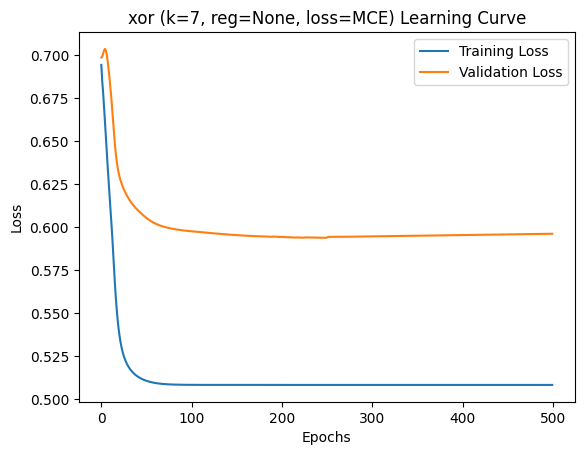

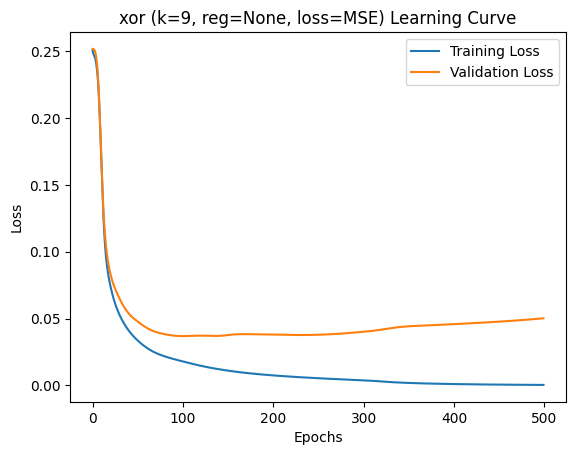

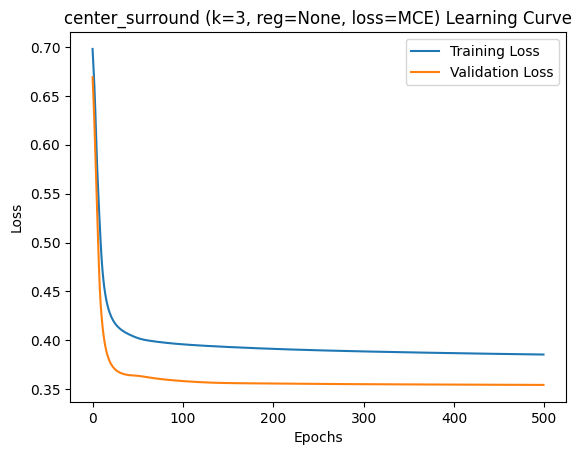

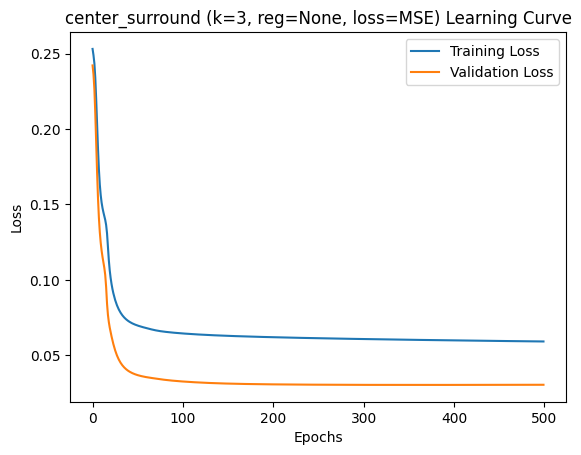

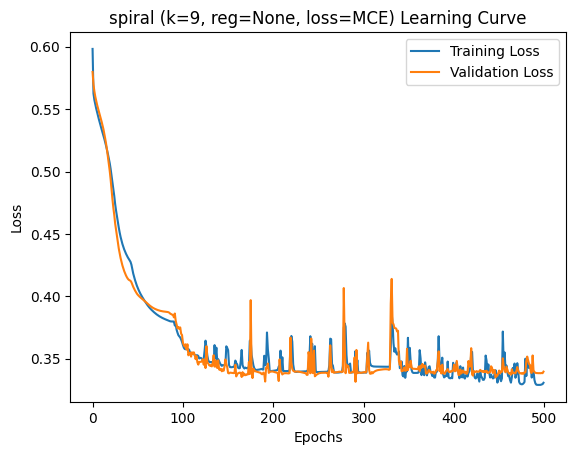

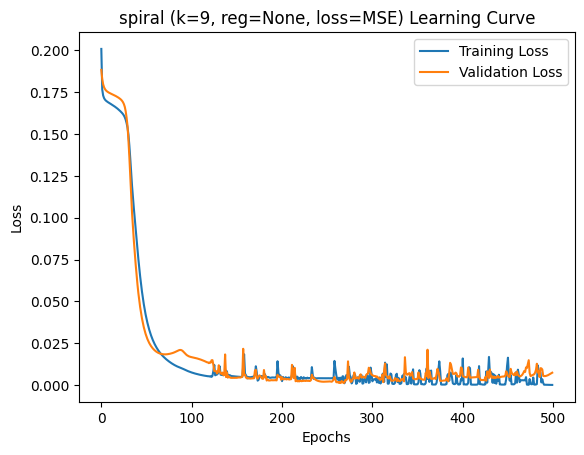

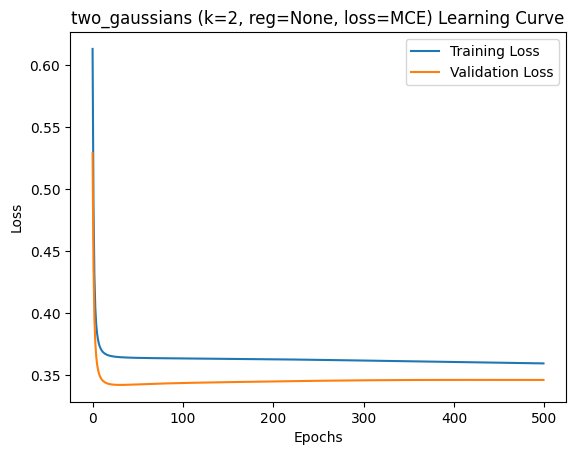

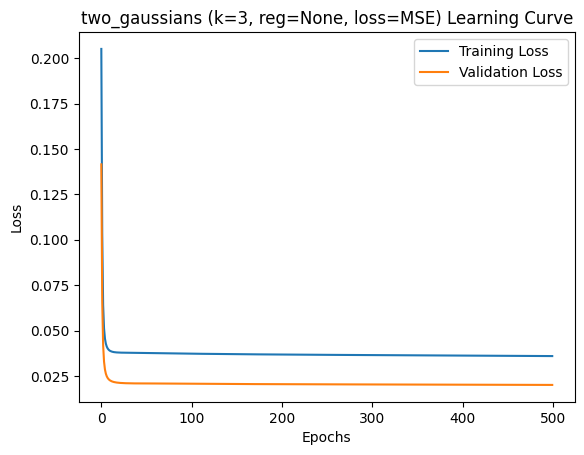

In [15]:
# Run the evaluation
evaluate_models_on_all_datasets()

# Part 3: Manual Gradients and Updates

In [16]:
# Part 3 Code here

# Part 4: Regularizers
Repeat parts 1 and 2 with regularizers.

In [ ]:
def evaluate_models_on_all_datasets():
    print(f"WARNING: This script will take a long time to run ...")
    evaluator = NeuralNetEvaluator(
        training_data={"xor": "xor_train.csv",
                       "center_surround": "center_surround_train.csv",
                       "spiral": "spiral_train.csv",
                       "two_gaussians": "two_gaussians_train.csv"
                       },
        test_data={"xor": "xor_test.csv",
                   "center_surround": "center_surround_test.csv",
                   "spiral": "spiral_test.csv",
                   "two_gaussians": "two_gaussians_test.csv"
                   },
        validation_data={"xor": "xor_valid.csv",
                         "center_surround": "center_surround_valid.csv",
                         "spiral": "spiral_valid.csv",
                         "two_gaussians": "two_gaussians_valid.csv"
                         },
        loss_functions={"MCE": nn.CrossEntropyLoss(), "MSE": nn.MSELoss()}
    )
    datasets = ["xor", "center_surround", "spiral", "two_gaussians"]
    hidden_layer_sizes = [2, 3, 5, 7, 9]
    losses = ["MSE"]
    regularizers = ["", "norm", "orthogonal"]
    # After running and manually inspecting the results,
    # these are the best HPs for each dataset and loss function
    # These should also be used when using regularizers
    best_hps_map = {
        "xor_MCE": HyperParams(7, 0.01, "MCE"),
        "xor_MSE": HyperParams(9, 0.01, "MSE"),
        "center_surround_MCE": HyperParams(3, 0.01, "MCE"),
        "center_surround_MSE": HyperParams(3, 0.01, "MSE"),
        "spiral_MCE": HyperParams(9, 0.01, "MCE"),
        "spiral_MSE": HyperParams(9, 0.01, "MSE"),
        "two_gaussians_MCE": HyperParams(2, 0.01, "MCE"),
        "two_gaussians_MSE": HyperParams(3, 0.01, "MSE")
    }
    for reg in regularizers:
        for dataset in tqdm(datasets, desc="Datasets"):
            for loss in losses:
                dataset_loss = f"{dataset}_{loss}"
                hp = best_hps_map[dataset_loss]
                evaluator.train_model(dataset, loss, reg, hp)
        # Uncomment this block to train models with different hyperparams
        # for dataset in tqdm(datasets, desc="Datasets"):
        #     for hl_size in hidden_layer_sizes:
        #         for loss in losses:
        #             hp = HyperParams(hl_size, 0.01, loss)
        #             evaluator.train_model(dataset, loss, hp)
        evaluator.print_evaluated_models()
        for dataset in datasets:
            for loss_name in losses:
                best_hp, valid_acc, test_acc = evaluator.find_best_hyperparams_for_dataset(
                    dataset, loss_name
                )
                print("======================================")
                print(
                    f'Best Hyperparams for {dataset}: ' +
                    f'{best_hp} Reg={'None' if reg == '' else reg}'
                )
                print(f"Validation Accuracy: {valid_acc}")
                print(f"Test Accuracy: {test_acc}")
                print("======================================\n")
                evaluator.plot_learning_curves(dataset, best_hp)
                evaluator.plot_learned_decision_surfaces(
                    dataset, loss_name, reg)
    print(f"============ Finished training and evaluating models ============")

Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  25%|██▌       | 1/4 [00:22<01:06, 22.30s/it]

Finished training xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  50%|█████     | 2/4 [00:43<00:43, 21.84s/it]

Finished training center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  75%|███████▌  | 3/4 [01:05<00:21, 21.74s/it]

Finished training spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets: 100%|██████████| 4/4 [01:26<00:00, 21.65s/it]

Finished training two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: None
Evaluated 4 models over 4 datasets
xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.93
Test Accuracy: 0.97

center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.965
Test Accuracy: 0.725

spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.99
Test Accuracy: 0.995

two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.975
Test Accuracy: 0.915

Best Hyperparams for xor: [HLSize: 9, LR: 0.01, Loss: MSE] Reg=None
Validation Accuracy: 0.93
Test Accuracy: 0.97

Drawing Decision Region for xor_MSE_
Best Hyperparams for center_surround: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=None
Validation Accuracy: 0.965
Test Accuracy: 0.725

Drawing Decision Region for center_surround_MSE_
Best Hyperparams for spiral: [HLSize: 9, LR: 0.01, Loss: MSE] Reg=No

Drawing Decision Region for spiral_MSE_
Best Hyperparams for two_gaussians: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=None
Validation Accuracy: 0.975
Test Accuracy: 0.915

Drawing Decision Region for two_gaussians_MSE_


Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  25%|██▌       | 1/4 [00:23<01:11, 23.81s/it]

Finished training xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: norm
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  50%|█████     | 2/4 [00:47<00:47, 23.74s/it]

Finished training center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: norm
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  75%|███████▌  | 3/4 [01:10<00:23, 23.61s/it]

Finished training spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: norm
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets: 100%|██████████| 4/4 [01:34<00:00, 23.70s/it]

Finished training two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: norm
Evaluated 4 models over 4 datasets
xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.455
Test Accuracy: 0.54

center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.5
Test Accuracy: 0.5

spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.955
Test Accuracy: 0.96

two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.98
Test Accuracy: 0.915

Best Hyperparams for xor: [HLSize: 9, LR: 0.01, Loss: MSE] Reg=norm
Validation Accuracy: 0.455
Test Accuracy: 0.54

Drawing Decision Region for xor_MSE_norm
Best Hyperparams for center_surround: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=norm
Validation Accuracy: 0.5
Test Accuracy: 0.5

Drawing Decision Region for center_surround_MSE_norm
Best Hyperparams for spiral: [HLSize: 9, LR: 0.01, Loss: MSE] Reg=n

Drawing Decision Region for spiral_MSE_norm
Best Hyperparams for two_gaussians: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=norm
Validation Accuracy: 0.98
Test Accuracy: 0.915

Drawing Decision Region for two_gaussians_MSE_norm


Datasets:   0%|          | 0/4 [00:00<?, ?it/s]

Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  25%|██▌       | 1/4 [00:27<01:21, 27.09s/it]

Finished training xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: orthogonal
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  50%|█████     | 2/4 [00:53<00:53, 26.61s/it]

Finished training center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: orthogonal
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets:  75%|███████▌  | 3/4 [01:20<00:27, 27.04s/it]

Finished training spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: orthogonal
Using cuda for training


/home/sharwin/fall_2024/MSAI349_Machine_Learning/nn-venv/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Datasets: 100%|██████████| 4/4 [01:47<00:00, 26.76s/it]

Finished training two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE] with loss function: MSE and regularizer: orthogonal
Evaluated 4 models over 4 datasets
xor with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.895
Test Accuracy: 0.915

center_surround with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.98
Test Accuracy: 0.725

spiral with Hyperparams: [HLSize: 9, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.96
Test Accuracy: 0.975

two_gaussians with Hyperparams: [HLSize: 3, LR: 0.01, Loss: MSE]
Validation Accuracy: 0.975
Test Accuracy: 0.91

Best Hyperparams for xor: [HLSize: 9, LR: 0.01, Loss: MSE] Reg=orthogonal
Validation Accuracy: 0.895
Test Accuracy: 0.915

Drawing Decision Region for xor_MSE_orthogonal
Best Hyperparams for center_surround: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=orthogonal
Validation Accuracy: 0.98
Test Accuracy: 0.725

Drawing Decision Region for center_surround_MSE_orthogonal
Best Hyperparams for spiral: 


/tmp/ipykernel_10567/1396162206.py:351: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Drawing Decision Region for spiral_MSE_orthogonal
Best Hyperparams for two_gaussians: [HLSize: 3, LR: 0.01, Loss: MSE] Reg=orthogonal
Validation Accuracy: 0.975
Test Accuracy: 0.91

Drawing Decision Region for two_gaussians_MSE_orthogonal
============ Finished training and evaluating models ============


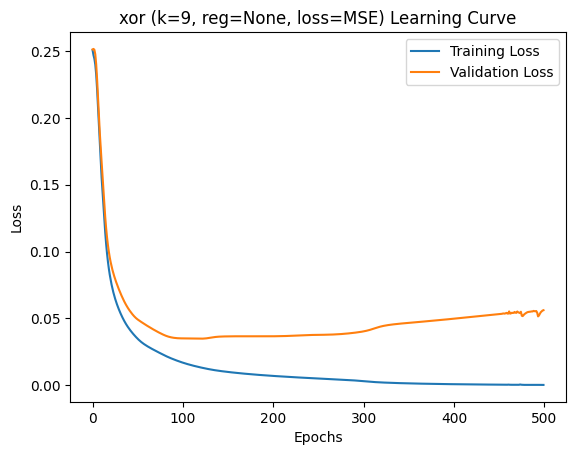

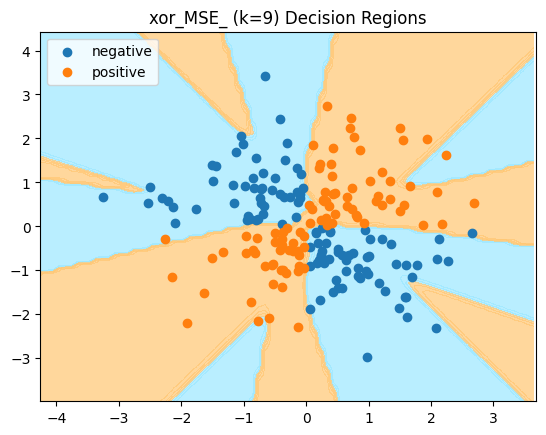

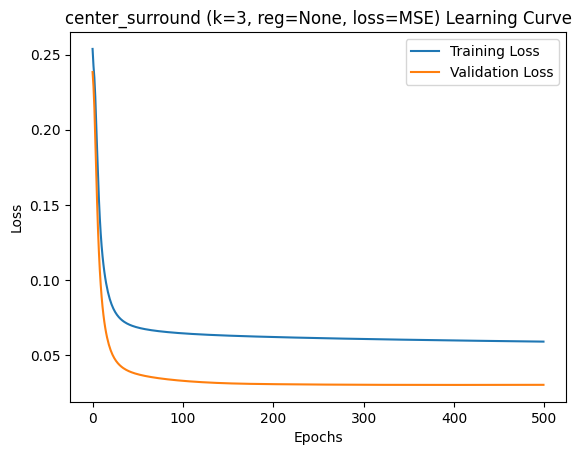

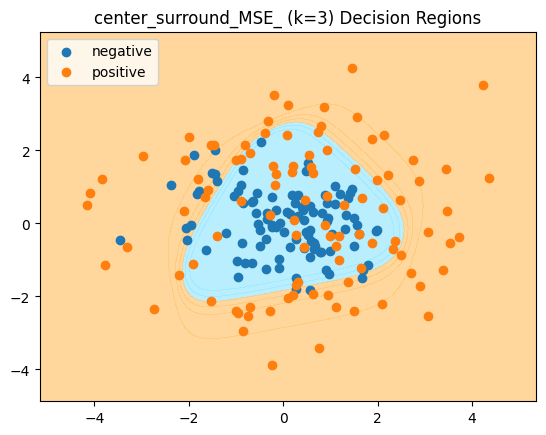

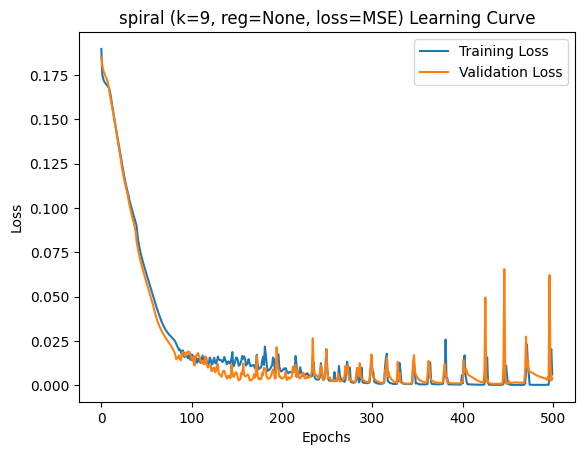

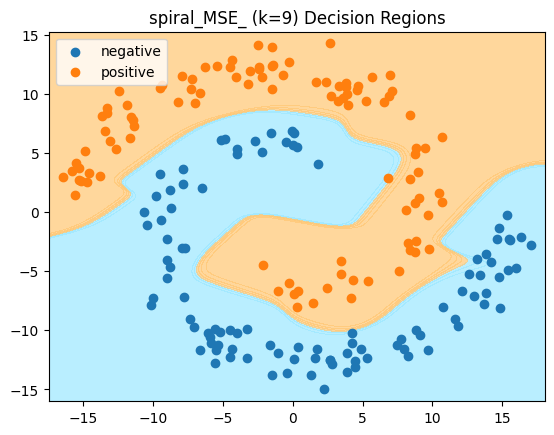

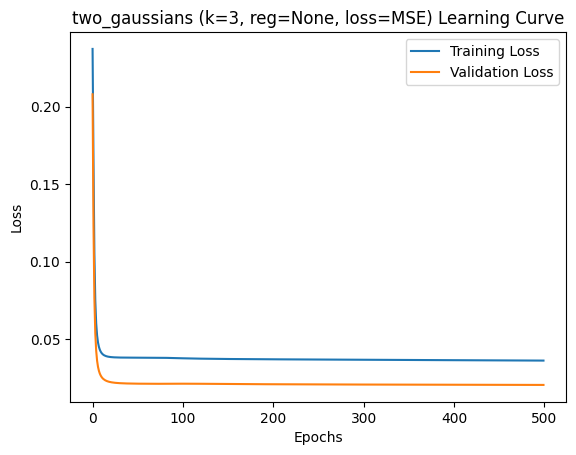

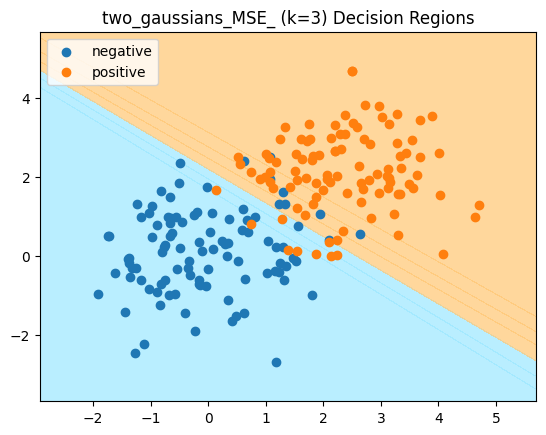

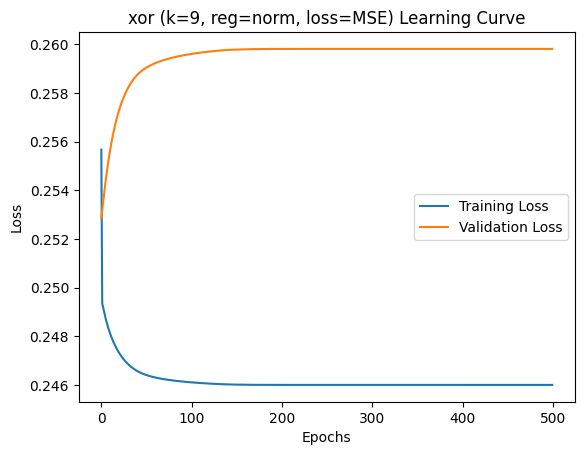

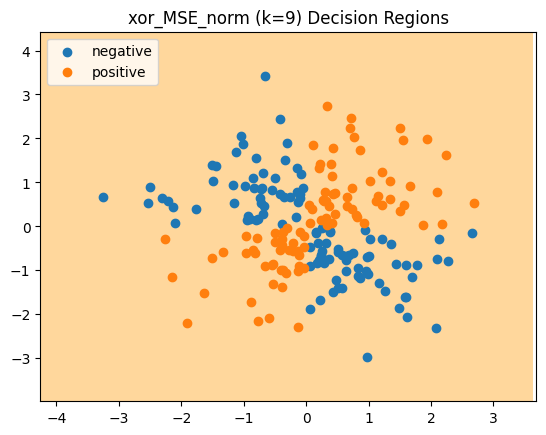

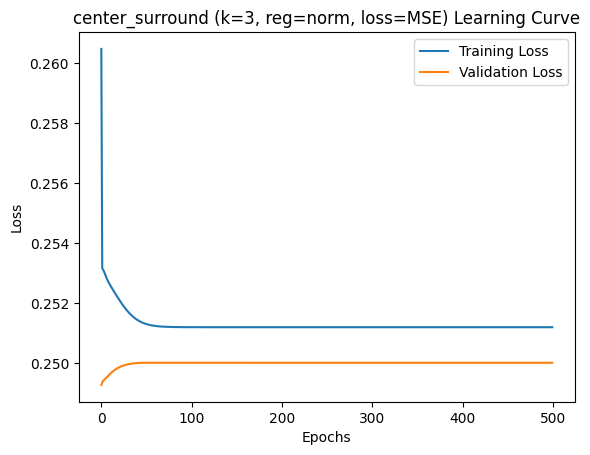

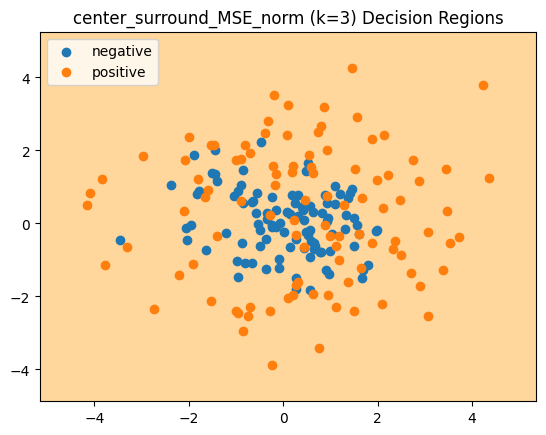

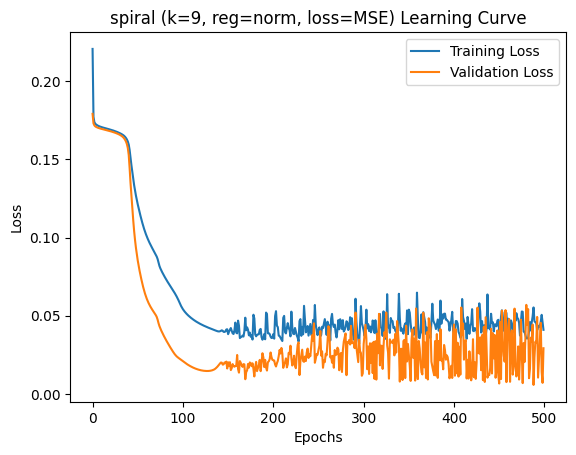

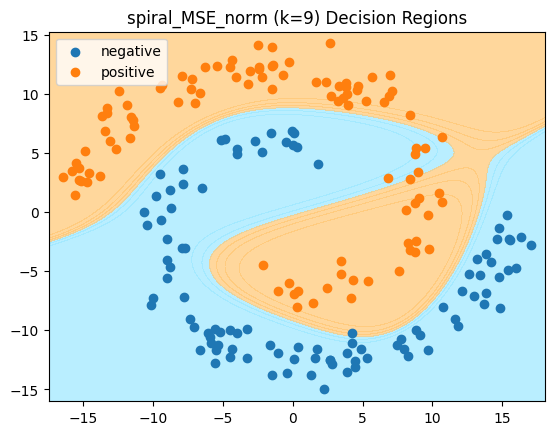

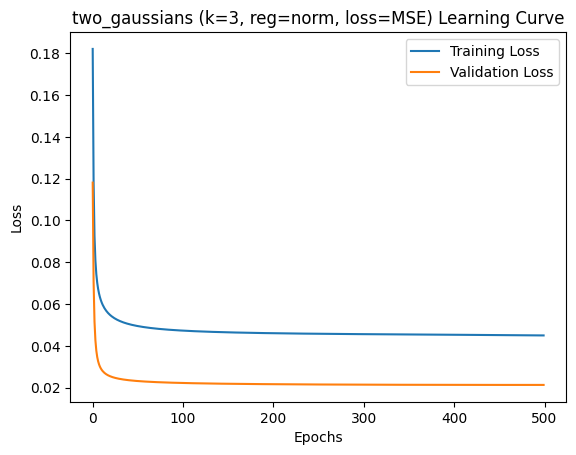

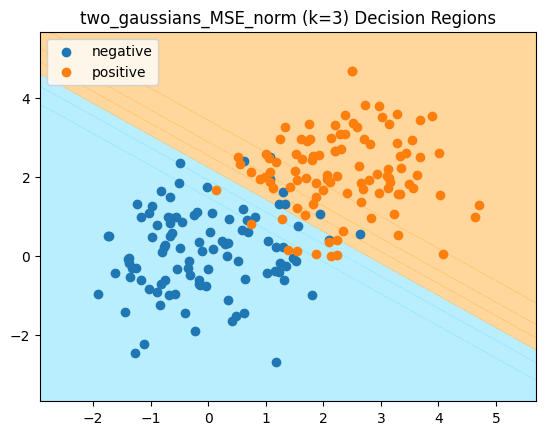

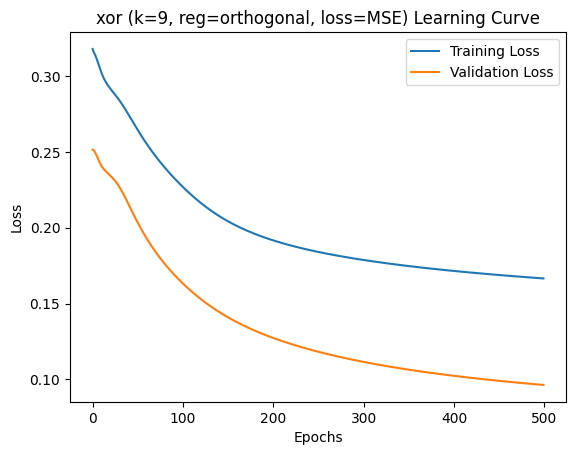

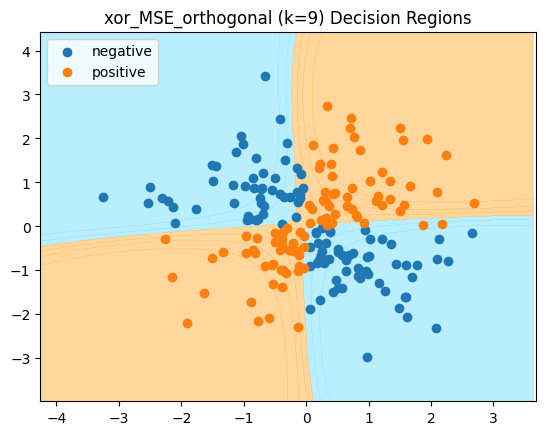

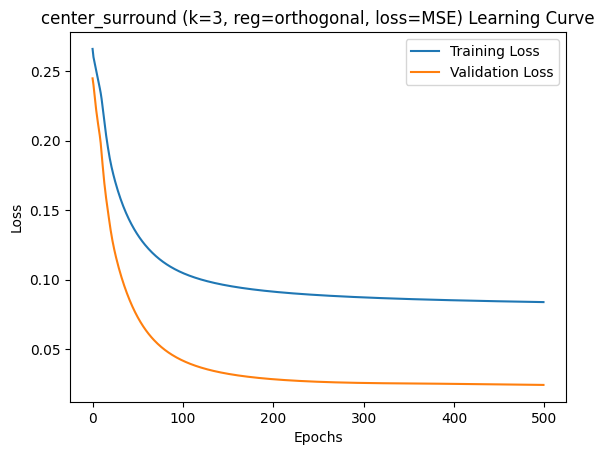

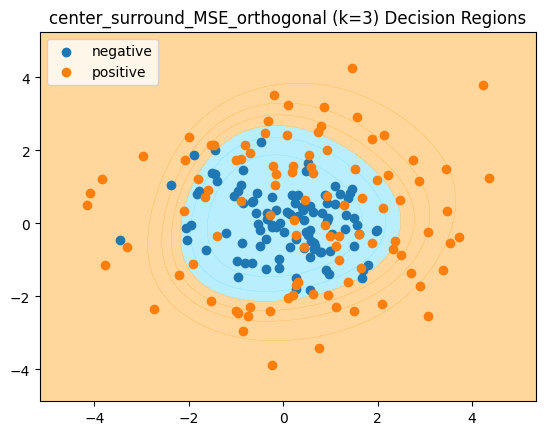

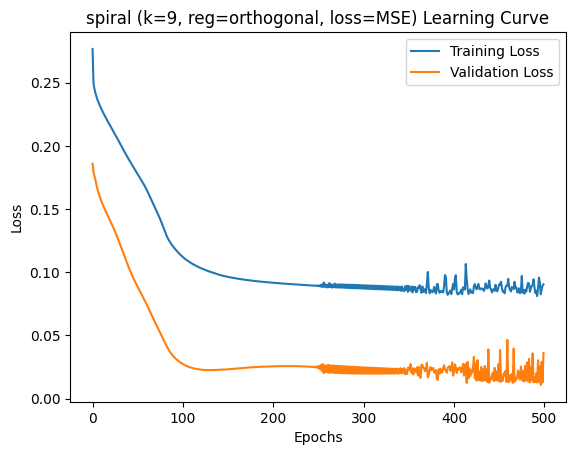

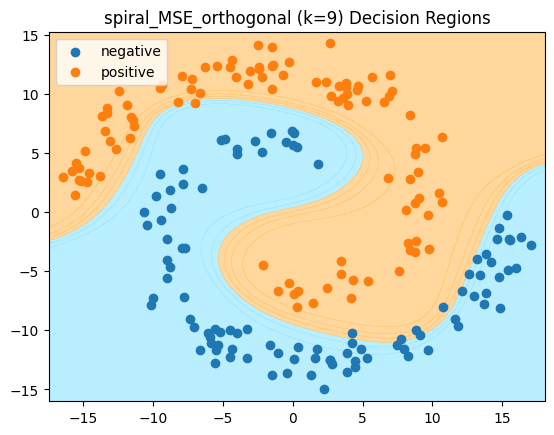

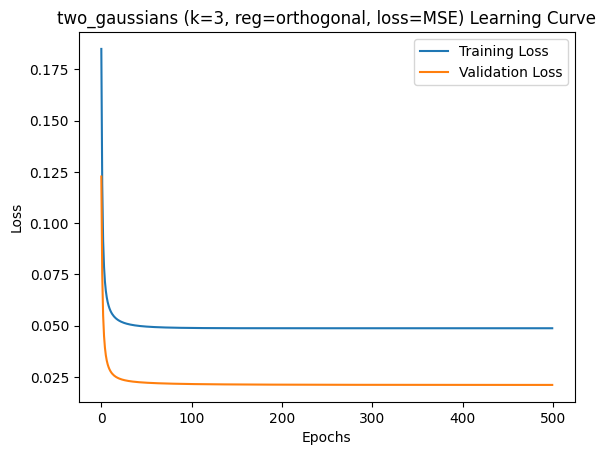

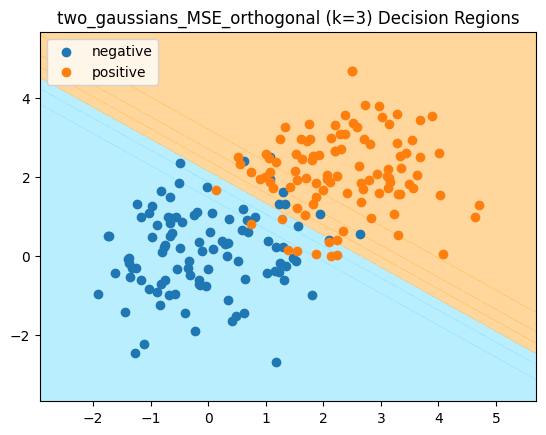

In [21]:
# Run the evaluation
evaluate_models_on_all_datasets()